# 230518_causal_tracing_activations_v3
Religion_and_belief_systems and layer level

# Import libraries

In [ ]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer
from datasets import load_dataset
from tqdm import tqdm
import json
import torch
import argparse
import datasets
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt

# Config

In [ ]:
dataset_nm = "Religion_and_belief_systems"
# dataset_path = f"../m2d2/dataset/{dataset_nm}/train.txt"

In [ ]:
device_id = 'cuda'
tuned_model_path = "../m2d2/dataset/Religion_and_belief_systems/models/"
n_layers = 12
list_modules = ['attn', 'mlp']
trace_module_id = "transformer.h.{l}.{m}"

In [5]:
list_trace_module_ids = []

for l in range(n_layers):
    for m in list_modules:
        list_trace_module_ids.append(trace_module_id.format(l=l, m=m))

print(list_trace_module_ids[:3])

['transformer.h.0.attn', 'transformer.h.0.mlp', 'transformer.h.1.attn']


# Model

## load models

In [6]:
base_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device_id)
tuned_model = GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [230]:
base_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device_id)
tuned_model = GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)

## save_tuned_model_activation_hook

In [7]:
def save_tuned_model_activation(m_id):
    def save_tuned_model_activation_hook(module, _input, _output):
        if m_id.endswith('attn'):
            tuned_model_activations[m_id] = _output[0].detach()
        elif m_id.endswith('mlp'):
            tuned_model_activations[m_id] = _output.detach()
    return save_tuned_model_activation_hook

## restore_tuned_model_activation_hook

In [9]:
# def restore_base_model_activation(m_id, t):
#     def restore_base_model_activation_hook(module, _input, _output):
#         tuned_output = tuned_model_activations[m_id][:, t]
#         if m_id.endswith('attn'):
#             base_output = _output[0].detach()
#             base_output[:, t] = tuned_output
#             return tuple([base_output, tuple([_output[1][0], _output[1][1]])])
#         elif m_id.endswith('mlp'):
#             base_output = _output.detach()
#             base_output[:, t] = tuned_output
#             return base_output
#     return restore_base_model_activation_hook


def restore_base_model_activation(m_id):
    def restore_base_model_activation_hook(module, _input, _output):
        tuned_output = tuned_model_activations[m_id]#[:, t]
        if m_id.endswith('attn'):
            base_output = _output[0].detach()
#             base_output[:, t] = tuned_output
            base_output = tuned_output
            return tuple([base_output, tuple([_output[1][0], _output[1][1]])])
        elif m_id.endswith('mlp'):
            base_output = _output.detach()
#             base_output[:, t] = tuned_output
            base_output = tuned_output
            return base_output
    return restore_base_model_activation_hook

In [10]:
# diff_weights = {}
# for tuned_tup, base_tup in zip(list(tuned_model.named_parameters()), list(base_model.named_parameters())):
#     diff_weights[tuned_tup[0]] = torch.abs(tuned_tup[1] - base_tup[1]).mean().item()
    
# diff_weights

# Data

In [11]:
dataset = load_dataset("machelreid/m2d2", dataset_nm)


Found cached dataset m2d2 (/rds/general/user/jj1122/home/.cache/huggingface/datasets/machelreid___m2d2/Religion_and_belief_systems/0.0.0/eb235f33a5de3163c10549b7f63c906910539c8a8c0ec5ade1285ccbf5067d00)
100%|██████████| 3/3 [00:00<00:00, 242.67it/s]


In [184]:
x = 10 * np.random.randint(100000)

dataset['train']['text'][x:x+10]

['In the "Dialogues", Hume\'s characters debate a number of arguments for the existence of God, and arguments whose proponents believe through which we may come to know the nature of God. Such topics debated include the argument from design—for which Hume uses a house—and whether there is more suffering or good in the world (argument from evil).',
 'Hume started writing the "Dialogues" in 1750 but did not complete them until 1776, shortly before his death. They are based partly on Cicero\'s "De Natura Deorum". The "Dialogues" were published posthumously in 1779, originally with neither the author\'s nor the publisher\'s name.',
 'In "The Blind Watchmaker" (1986), evolutionary biologist Richard Dawkins discussed his choice to title his book after theologian William Paley\'s famous statement of the teleological argument, the watchmaker analogy, and noted that Hume\'s critique of the argument from design as an explanation of design in nature was the initial criticism that would ultimately

In [185]:

input_text = "He was a religious scholar and a prolific writer. Many of his works are used as references for church members"

input_text = "In popular and media culture, Anubis is often falsely portrayed as the sinister god of the dead"

input_text = "Ankou appears as a man or skeleton wearing a black robe and a large hat which conceals his face, or, on occasion, simply as a shadow"

input_text = "Zechariah's vision of recently deceased Joshua the High Priest depicts a dispute in the heavenly throne room between Satan and the Angel of the Lord"

input_text = "The Transcendental Argument for the Existence of God (TAG) is the argument that attempts to prove the existence of God by arguing that logic, morals, and science ultimately presuppose a supreme being and that God must therefore be the source of logic and morals"


In [186]:
inputs = gpt2_tokenizer(input_text, return_tensors="pt").to(device_id)
n_tokens = inputs['input_ids'].shape[1]
n_tokens

52

In [187]:
list_input_text = gpt2_tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())

for idx in range(1, n_tokens):
    if not list_input_text[idx].startswith("Ġ"):
        list_input_text[idx-1] = list_input_text[idx-1] + "##"
    list_input_text[idx] = list_input_text[idx].replace("Ġ", "")

# Main

## first run - tuned model (clean)

### register hook - save_tuned_model_activation

In [188]:
tuned_model_activations = {}
for m_id in list_trace_module_ids:
    tuned_model.get_submodule(m_id).register_forward_hook(save_tuned_model_activation(m_id))

### get tuned_model_activation & tuned_loss

In [189]:
with torch.no_grad():
    tuned_model.eval()
    tuned_outputs = tuned_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)    
    tuned_loss = np.exp(tuned_outputs.loss.item())
    

## second run - base model (corruped)

### get tuned_model_activation & base_loss

In [190]:
with torch.no_grad():
    base_model.eval()
    base_outputs = base_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)
    base_loss = np.exp(base_outputs.loss.item())
    

## Thrid run - corrupted-with-restoration run

### register hook - restore_base_model_activation & restored losses

In [191]:
# restored_loss = {}
# with torch.no_grad():
#     tuned_model.eval()
#     base_model.eval()
#     for m_id in list_trace_module_ids:
#         for t in range(n_tokens):
#             hook = base_model.get_submodule(m_id).register_forward_hook(restore_base_model_activation(m_id, t))
#             restored_outputs = base_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)
#             restored_loss[m_id + f".{t}"] = np.exp(restored_outputs.loss.item())
#             hook.remove()

restored_loss = {}
with torch.no_grad():
    tuned_model.eval()
    base_model.eval()
    for m_id in list_trace_module_ids:
#         for t in range(n_tokens):
        hook = base_model.get_submodule(m_id).register_forward_hook(restore_base_model_activation(m_id))
        restored_outputs = base_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)
        restored_loss[m_id] = np.exp(restored_outputs.loss.item())
        hook.remove()
        

In [192]:
list(restored_loss.items())[:10]

[('transformer.h.0.attn', 20.01987558304445),
 ('transformer.h.0.mlp', 19.224473884251445),
 ('transformer.h.1.attn', 20.266302507933972),
 ('transformer.h.1.mlp', 20.01359992683733),
 ('transformer.h.2.attn', 20.432266746563865),
 ('transformer.h.2.mlp', 19.856105909906205),
 ('transformer.h.3.attn', 20.240410611904498),
 ('transformer.h.3.mlp', 19.668937658090545),
 ('transformer.h.4.attn', 20.405939018985784),
 ('transformer.h.4.mlp', 19.561963365582674)]

## Losses

In [193]:
tuned_loss, base_loss, np.mean(list(restored_loss.values()))

(13.573352837326823, 20.486738508955135, 19.729322115422764)

In [194]:
# TE = (base_loss - tuned_loss) / base_loss
# IDE = {}
# for m_id in list_trace_module_ids:
#     for t in range(n_tokens):
#         IDE[m_id + f'.{t}'] = restored_loss[m_id + f'.{t}'] / base_loss
        
TE = (base_loss - tuned_loss) / base_loss
IDE = {}
for m_id in list_trace_module_ids:
    IDE[m_id] = restored_loss[m_id] / base_loss

In [195]:
def parse_code(row):
    list_code = row.code.split(".")
    row['l'] = int(list_code[2])
    row['m'] = list_code[3]
#     row['t'] = int(list_code[4])
    return row

df_ide = pd.DataFrame.from_dict(IDE, orient='index').reset_index()
df_ide.columns = ['code', 'ide']
df_ide = df_ide.apply(lambda row: parse_code(row), axis=1)
# df_ide['token'] = df_ide['t'].apply(lambda x: list_input_text[int(x)])

## Results

##### He was a religious scholar and a prolific writer. Many of his works are used as references for church members

<Axes: xlabel='None-l', ylabel='m'>

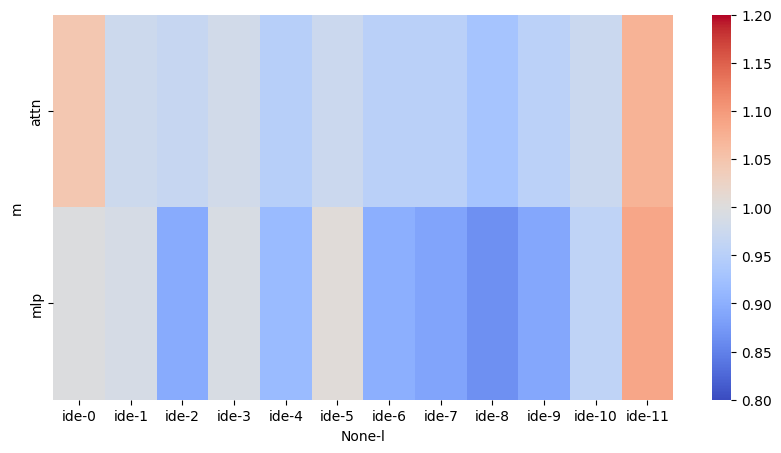

In [128]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm', vmax=1.2, vmin=0.8
)

##### 'In popular and media culture, Anubis is often falsely portrayed as the sinister god of the dead'


<Axes: xlabel='None-l', ylabel='m'>

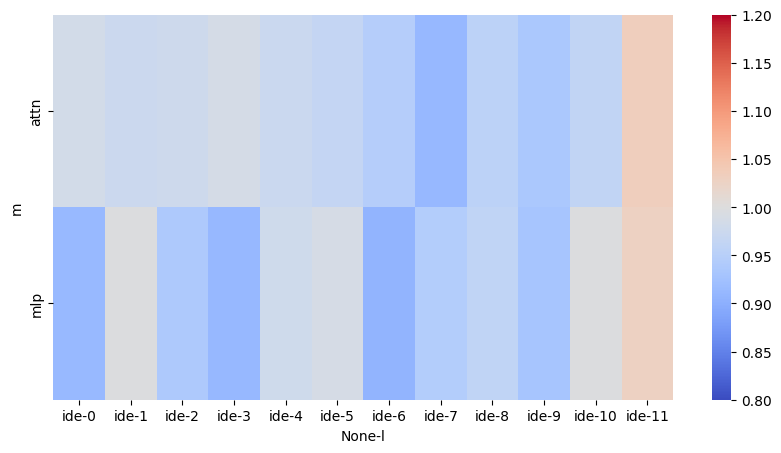

In [115]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm', vmax=1.2, vmin=0.8
)

##### Elderly people often have limited regenerative abilities and are more susceptible to disease, syndromes, injuries and sickness than younger adults.

<Axes: xlabel='None-l', ylabel='m'>

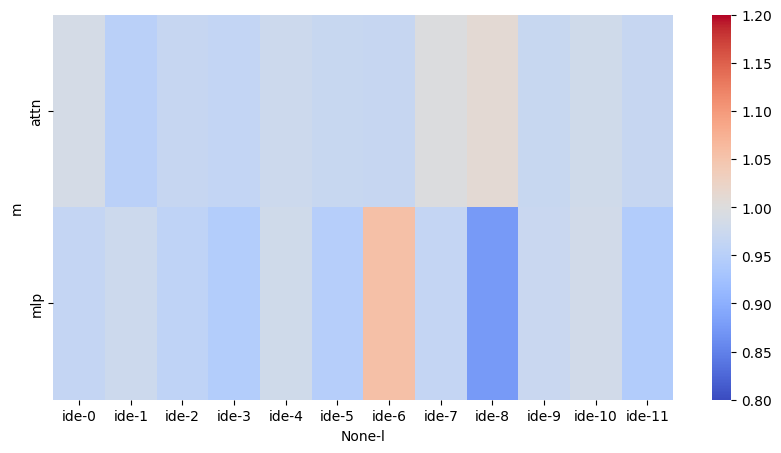

In [141]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm', vmax=1.2, vmin=0.8
)

##### "Zechariah's vision of recently deceased Joshua the High Priest depicts a dispute in the heavenly throne room between Satan and the Angel of the Lord"


<Axes: xlabel='None-l', ylabel='m'>

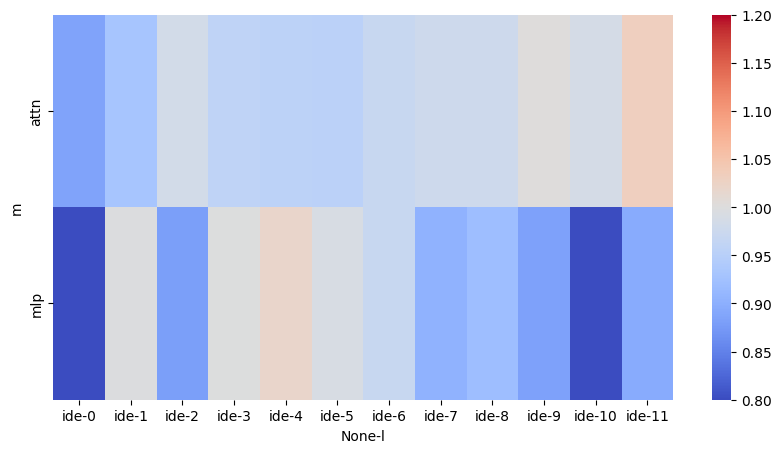

In [157]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm', vmax=1.2, vmin=0.8
)

##### The Transcendental Argument for the Existence of God (TAG) is the argument that attempts to prove the existence of God by arguing that logic, morals, and science ultimately presuppose a supreme being and that God must therefore be the source of logic and morals

<Axes: xlabel='None-l', ylabel='m'>

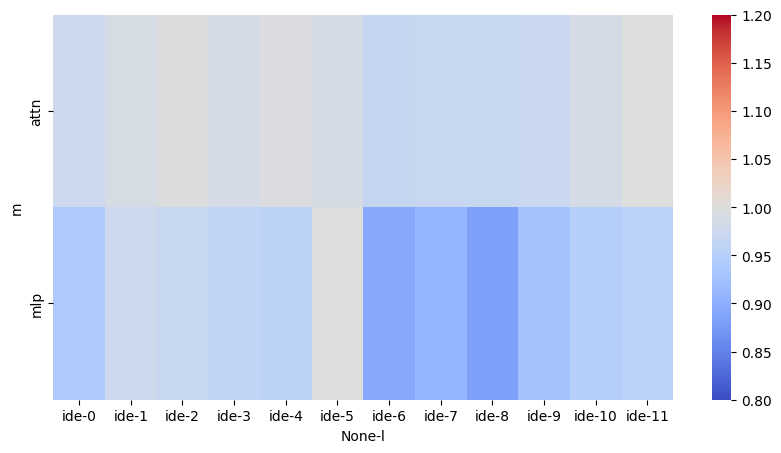

In [196]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm', vmax=1.2, vmin=0.8
)

### Conclusion
- When restore MLP activation, the model shows better result
- but the layer order doesn't show any pattern.

### Questions
- Q1) Multiple models in casual tracing?: I guess because of other weight differences between base and fine-tuned models despite the restored activations, the restoration wouldn’t work properly. The restored values from the tuned model would be re-changed by the weights and baises in the base model.
- Q2) Constraint on dataset: they used **triples (subject, relation, object)**, and as far as I understand, they constrained the templates which they build. Most **subject tokens** appear in the heads of templates and **object** appear in the back to track the result efficiently. Do we need to constrain dataset too?
